In [2]:
import numpy as np, os
from matplotlib import pyplot as plt
import h5py as h5

%matplotlib inline

/Users/carina/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data_dir = '../data/BPASS/BPASSv2.2/'

In [4]:
modeltypes = ['sin','bin']
zs = ['zem5','zem4','z001','z002','z004','z006','z008','z010','z014','z020','z030','z040']
cols_dict = {'O':(1,),'Of':(2,),'B':(3,),'A':(4,),'FG':(5,),'K':(6,),'M':(7,),'WNH':(8,),'WN':(9,),'WC':(10,),'RSG':(6,7),'WR':(8,9,10),'BSG':(1,2,3,4),'YSG':(5,)}
subtypes = list(cols_dict.keys())
Lcuts = [0.0] + [3.0 + 0.1*i for i in range(31)]

In [5]:
def data_file_lookup(modeltype, z, subtype, Lcut = 0.0):
    """
    Gets the number counts vs. time arrays from data_dir
    
    Parameters
    ----------
    modeltype : str
        'sin' or 'bin' indicating 100% singles or 100% binaries
    z : str
        Metallicity. Formatted like BPASS.
    subtype : str
        Stellar subtype. Must be in subtypes array
    L_cut : float
        Lower luminosity cutoff. Can be 0.0 (default), or between 3.0 and 5.0 in 
        steps of 0.1
    """
    
    assert modeltype in modeltypes, "modeltypes must be 'sin' or 'bin'"
    
    assert z in zs, "z must be a valid BPASS metallicity"
    
    assert subtype in subtypes, "subtype must be a valid subtype in subtypes"
    
    assert Lcut in Lcuts, "L_cut must be 0.0, or between 3.0 and 5.0 in steps of 0.1"
    
    filename = data_dir+'ncounts_{0}_{1}_{2}.dat'.format(z, modeltype, int(10*Lcut))
    
    assert os.path.exists(filename), "Something is wrong and I can't find the datafile you want"
    
    cols = tuple([0]+list(cols_dict[subtype]))
    
    data = np.genfromtxt(filename, usecols=cols)
    
    logtime = data[:,0]
    ncounts = np.sum(data[:,1:],axis=1)
    return logtime,ncounts

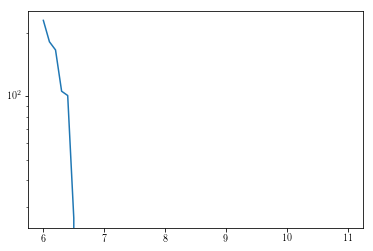

In [6]:
#looks like this works?
logtime,ncounts = data_file_lookup('sin','z014', 'O',Lcut=5.9)
plt.semilogy(logtime,ncounts)

In [12]:
#This cell creates the file from scratch!! Don't run it if you don't need it.
ncounts_h5.close()
ncounts_h5 = h5.File("ncounts.hdf5", "w")
ncounts_h5.create_dataset('logtime', data=logtime)
ncounts_h5.create_dataset('meta', shape=(0,), dtype=int)
ncounts_h5['meta'].attrs.create('modeltypes',[a.encode('utf8') for a in modeltypes])
ncounts_h5['meta'].attrs.create('zs',[a.encode('utf8') for a in zs])
ncounts_h5['meta'].attrs.create('subtypes',[a.encode('utf8') for a in subtypes])
ncounts_h5['meta'].attrs.create('Lcuts',Lcuts)
for modtype in modeltypes:
    for z in zs:
        for subtype in subtypes:
            for Lcut in Lcuts:
                try: #just in case any of the files you need are missing
                    logtime,ncounts = data_file_lookup(modtype,z,subtype,Lcut=Lcut)
                except:
                    print(modtype,z,subtype,Lcut)
                ncounts_h5.create_dataset('{0}/{1}/{2}/{3}/ncounts'.format(modtype,z,subtype,str(Lcut)),data=ncounts)
                ncounts_h5['{0}/{1}/{2}/{3}/ncounts'.format(modtype,z,subtype,str(Lcut))].attrs['modeltype'] = modtype
                ncounts_h5['{0}/{1}/{2}/{3}/ncounts'.format(modtype,z,subtype,str(Lcut))].attrs['z'] = z
                ncounts_h5['{0}/{1}/{2}/{3}/ncounts'.format(modtype,z,subtype,str(Lcut))].attrs['subtype'] = subtype
                ncounts_h5['{0}/{1}/{2}/{3}/ncounts'.format(modtype,z,subtype,str(Lcut))].attrs['Lcut'] = Lcut
ncounts_h5.close()

In [120]:
ncounts = h5.File('ncounts.hdf5','r')

In [134]:
list(ncounts['meta'].attrs)

['modeltypes', 'zs', 'subtypes', 'Lcuts']